In [1]:
import numpy as np
import xarray as xr

import gcsfs
import xgcm

import matplotlib.pyplot as plt
%matplotlib inline

## Load dataset
The ECCOv4 release 3 dataset includes both monthly averaged data and snapshots (`_snp`). Time points are set in the middle of the month for averages and at the beginning and end of the month for snapshots. ECCOv4r3 solution has been run from 1992 to 2015.

In [2]:
ds = xr.open_zarr(gcsfs.GCSMap('pangeo-data/ecco/eccov4r3'))

## Creating the grid object

In [3]:
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

In [4]:
grid = xgcm.Grid(ds, face_connections=face_connections)

## Create and Connect to Dask Distributed Cluster

In [6]:
from dask.distributed import Client, progress

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=20)
cluster

In [7]:
client = Client(cluster)
client

Client Scheduler: tcp://10.20.206.9:34600 Dashboard: /user/jetesdal/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Grid dimensions

In [8]:
# Cell x size at v location
dxG = ds.dxG

# Cell y size at u location
dyG = ds.dyG

# Cell z size
drF = ds.drF

### Volume

In [10]:
rA = ds.rA
hFacC = ds.hFacC

# Volume (m^3)
vol = (rA*drF*hFacC).transpose('face','k','j','i')

### Cell fraction

In [11]:
# Cell vertical fraction at u location
hFacW = ds.hFacW

# Cell vertical fraction at v location
hFacS = ds.hFacS

# Cell_vertical_fraction at center (tracer) location
hFacC = ds.hFacC

## Load variables

In [12]:
# Potential Temperature (degC)
THETA = ds.THETA.transpose('time','face','k','j','i')

In [13]:
# Zonal Mass-Weighted Comp of Velocity (m/s)
UVELMASS = ds.UVELMASS.transpose('time','face','k','j','i_g')

# Meridional Mass-Weighted Comp of Velocity (m/s)
VVELMASS = ds.VVELMASS.transpose('time','face','k','j_g','i')

# Vertical Mass-Weighted Comp of Velocity (m/s)
WVELMASS = ds.WVELMASS.transpose('time','face','k_l','j','i')

In [14]:
# Zonal Advective Flux of Pot.Temperature (degC.m^3/s)
ADVx_TH = ds.ADVx_TH.transpose('time','face','k','j','i_g')

# Meridional Advective Flux of Pot.Temperature (degC.m^3/s)
ADVy_TH = ds.ADVy_TH.transpose('time','face','k','j_g','i')

# Vertical Advective Flux of Pot.Temperature (degC.m^3/s)
ADVr_TH = ds.ADVr_TH.transpose('time','face','k_l','j','i')

## Advective flux
$$\vec{\bf{F_{adv}}} = {\vec{\bf{u}}} \;\cdot \theta + R$$

### Volume transport
Volume transports are calculated the same way as in the xgcm example (http://xgcm.readthedocs.io/en/latest/example_mitgcm.html#Divergence-Calculation). The only difference here is the omission of `hFacW` and `hFacS`. Including `hFacW` and `hFacS` in the calculation of the transport terms introduces unrealistic artifacts in the horizontal convergence near the ocean floor, which in turn causes the volume budget to be not balanced in the deeper ocean layers.

In [15]:
u_transport = (UVELMASS * dyG * drF).transpose('time','face','k','j','i_g')
v_transport = (VVELMASS * dxG * drF).transpose('time','face','k','j_g','i')
w_transport = (WVELMASS * rA).transpose('time','face','k_l','j','i')

### Interpolate temperature to velocity points

In [16]:
THETA_at_u = grid.interp(THETA, 'X', boundary='extend')
THETA_at_v = grid.interp(THETA, 'Y', boundary='extend')
THETA_at_w = grid.interp(THETA, 'Z', boundary='extend')

### Calculated advective fluxes ($^\circ C\,m^3 s^{-1}$)

In [17]:
ADVx_TH_uT = (u_transport * THETA_at_u)
ADVy_TH_vT = (v_transport * THETA_at_v)
ADVr_TH_wT = (w_transport * THETA_at_w)

## Comparison

In [19]:
t = 200
f = 1
k = 1

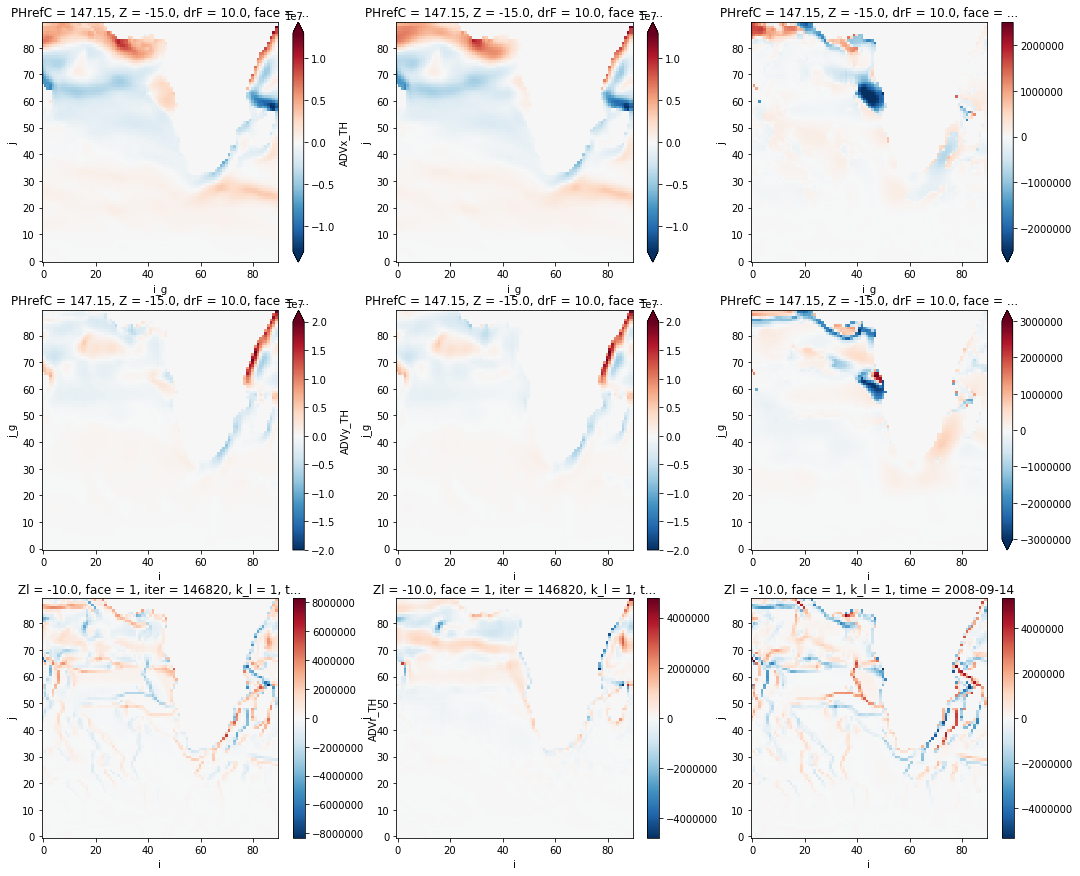

In [22]:
fig, axes = plt.subplots(3, 3,figsize=(18,15))

# Advective Flux along i
plt.subplot(3, 3, 1)
plt.title('ADVx_TH')
ADVx_TH[t,f,k].plot(vmax=1.3e7)

plt.subplot(3, 3, 2)
plt.title(r'$u\cdot\theta$')
ADVx_TH_uT[t,f,k].plot(vmax=1.3e7)

plt.subplot(3, 3, 3)
plt.title(r'Difference')
(ADVx_TH_uT[t,f,k]-ADVx_TH[t,f,k]).plot(vmax=2.5e6)

# Advective Flux along j
plt.subplot(3, 3, 4)
plt.title('ADVy_TH')
ADVy_TH[t,f,k].plot(vmax=2e7)

plt.subplot(3, 3, 5)
plt.title(r'$v\cdot\theta$')
ADVy_TH_vT[t,f,k].plot(vmax=2e7)

plt.subplot(3, 3, 6)
plt.title(r'Difference')
(ADVy_TH_vT[t,f,k]-ADVy_TH[t,f,k]).plot(vmax=3e6)

# Vertical advective flux
plt.subplot(3, 3, 7)
plt.title('ADVr_TH')
ADVr_TH[t,f,k].plot()#vmax=2e-8)

plt.subplot(3, 3, 8)
plt.title(r'$w\cdot\theta$)')
ADVr_TH_wT[t,f,k].plot()#vmax=2e-8)

plt.subplot(3, 3, 9)
plt.title(r'Difference')
(ADVr_TH_wT[t,f,k]-ADVr_TH[t,f,k]).plot()#vmax=2e-8)

plt.show()